In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import pandas as pd
import math
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

# Problem 1

## 1) Download the data

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

## 2) Find and describe how the background changes

In [3]:
df = pd.DataFrame(data).transpose()
df.columns = ["gps_time", "solar_phase", "longitude", "count"]

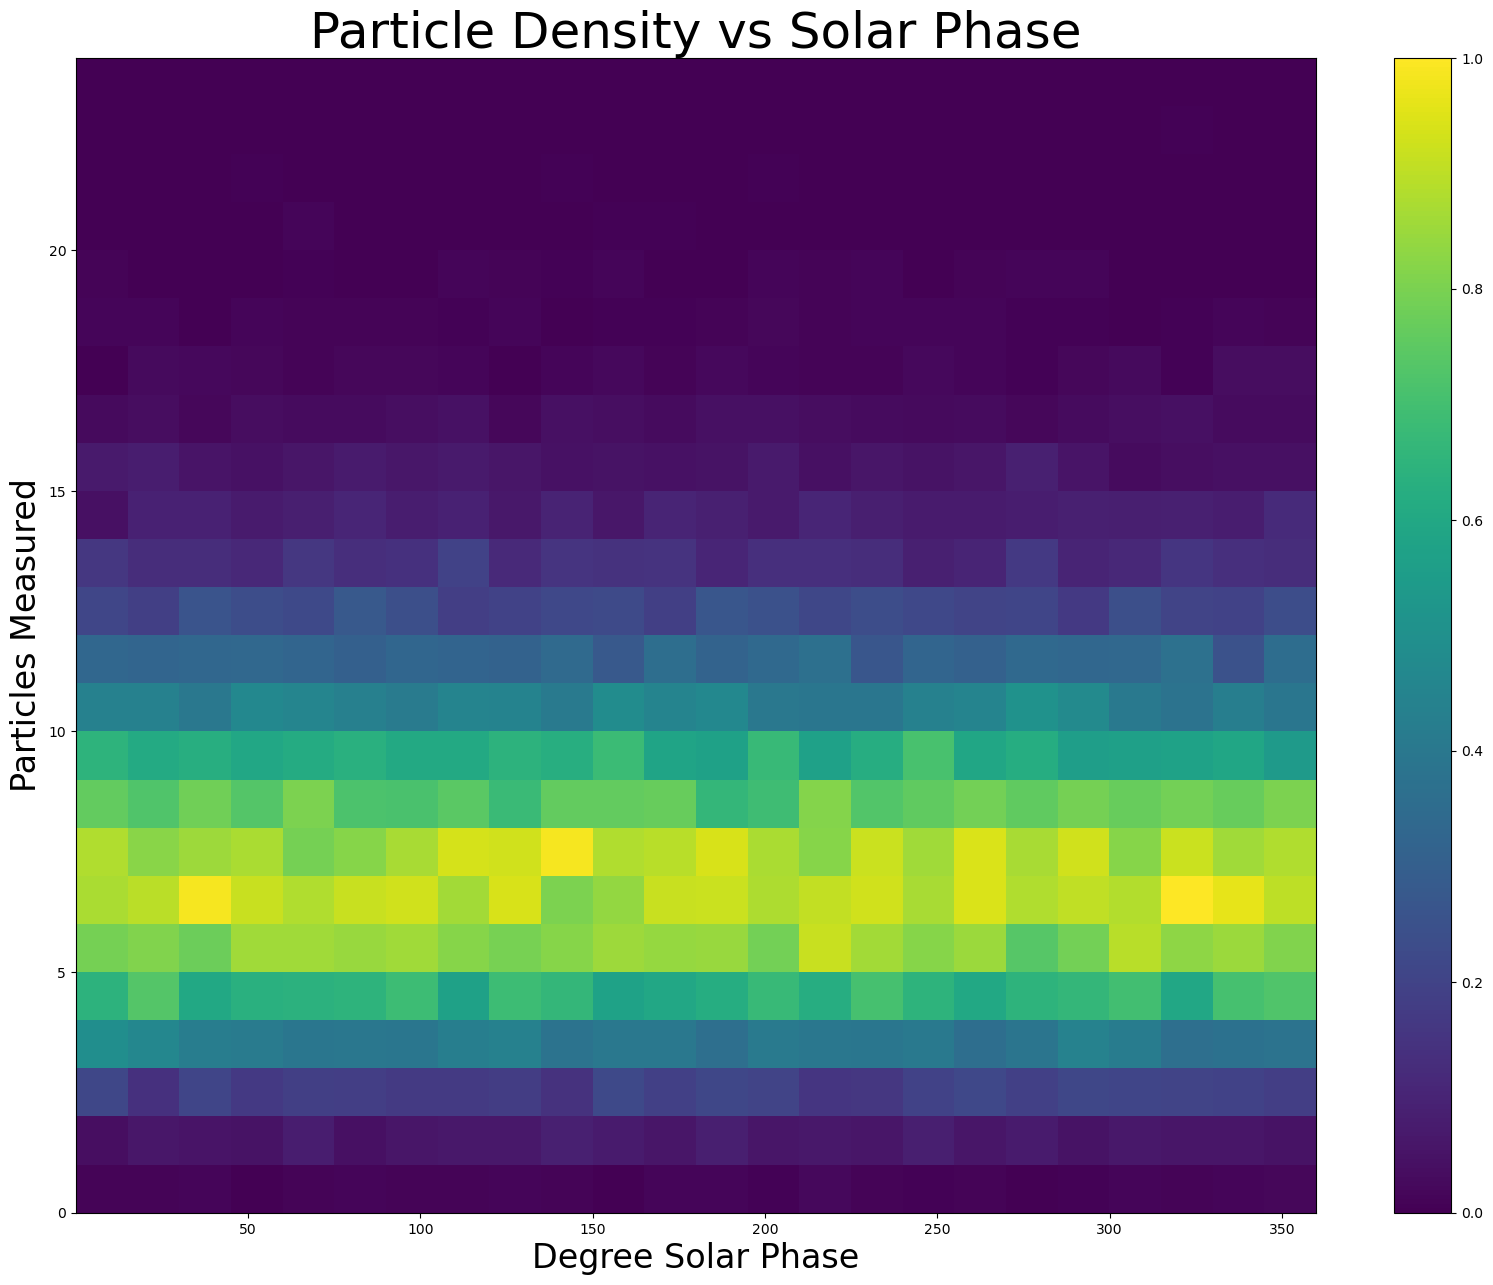

In [4]:
fig, ax = plt.subplots(1,1)
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.hist2d(df['solar_phase'][::500], df['count'][::500], bins = 24)
plt.xlabel("Degree Solar Phase", fontsize = 24)
plt.ylabel("Particles Measured", fontsize = 24)
plt.title("Particle Density vs Solar Phase", fontsize = 36)
plt.show()

We can see in the graph above the density of gamma ray measurement that there is very little to no dependance on the solar phase. At all points of solar phase, the density is relatively stable.

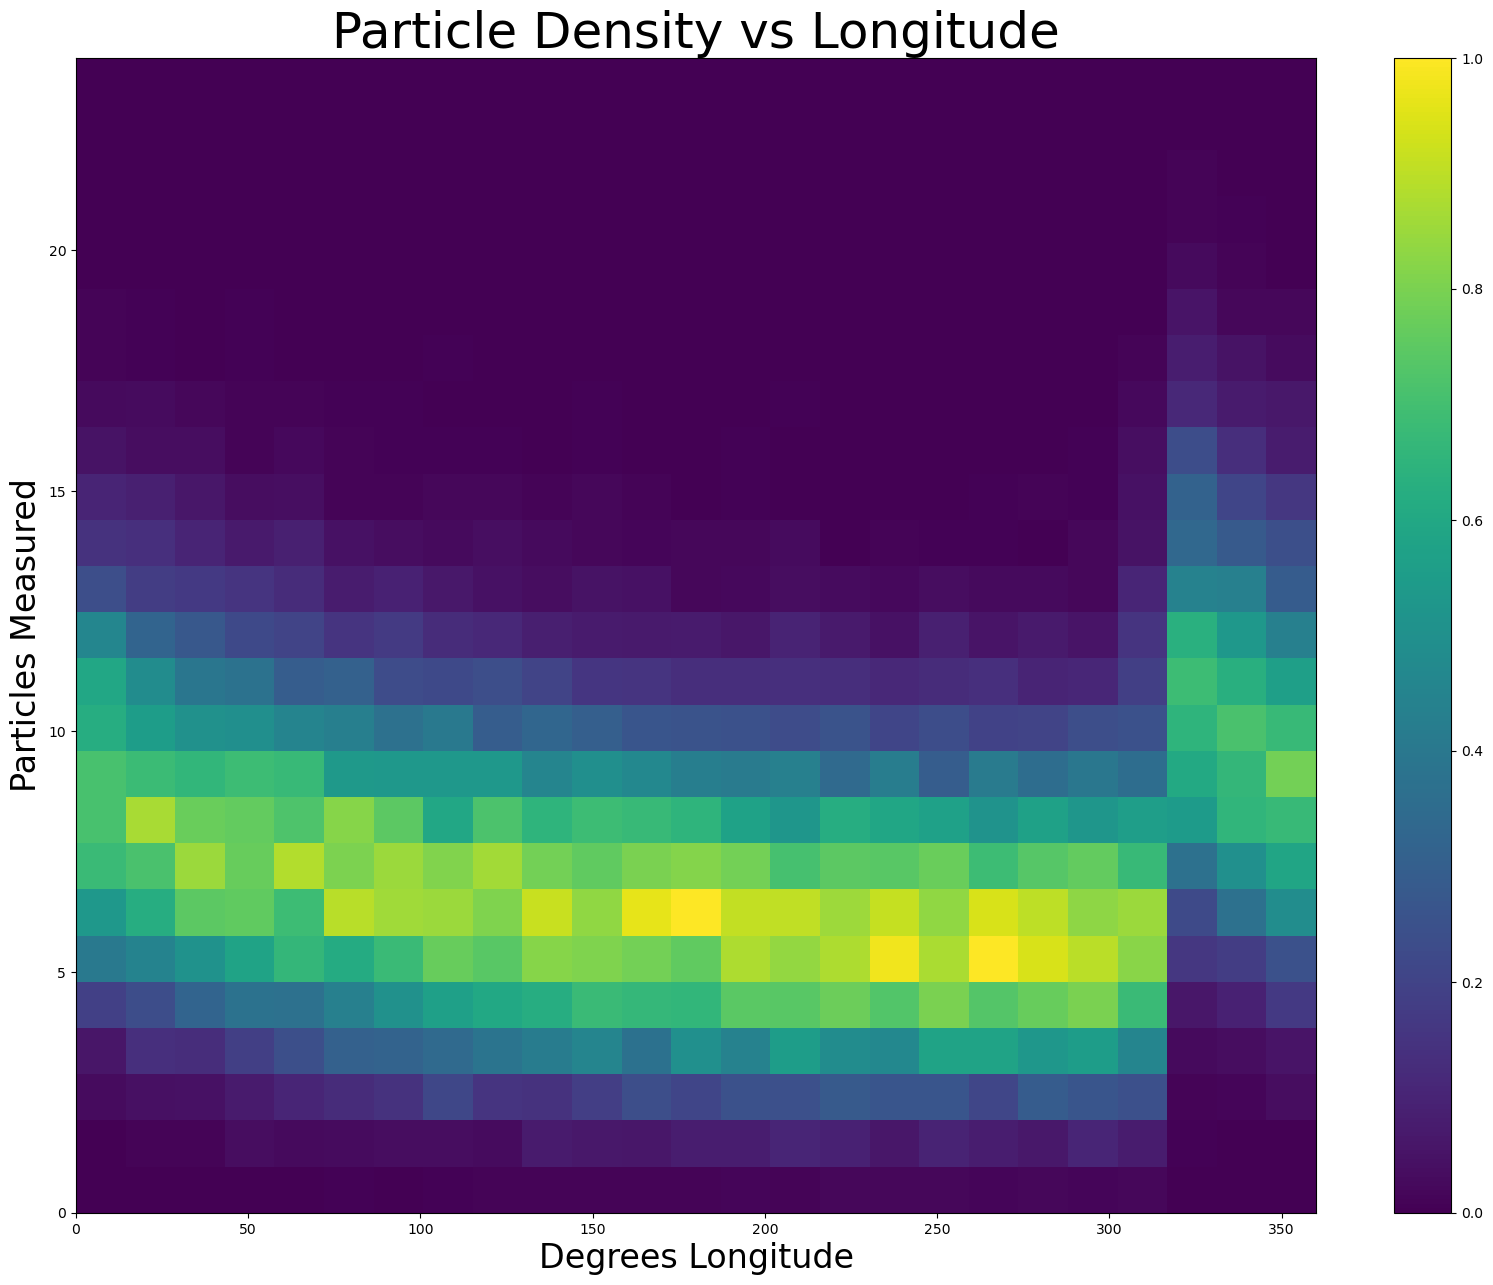

In [5]:
fig, ax = plt.subplots(1,1)
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.xlabel("Degrees Longitude", fontsize = 24)
plt.ylabel("Particles Measured", fontsize = 24)
plt.title("Particle Density vs Longitude", fontsize = 36)
plt.hist2d(df['longitude'][::502], df['count'][::502], bins = 25)
plt.show()

In [6]:
counts = [0]*360
for i in range(len(df["count"][::15])):
    counts[math.floor(df["longitude"][i*15])] += int(df["count"][i*15])
for i in range(len(counts)):
    counts[i] /= len(df["count"])/360

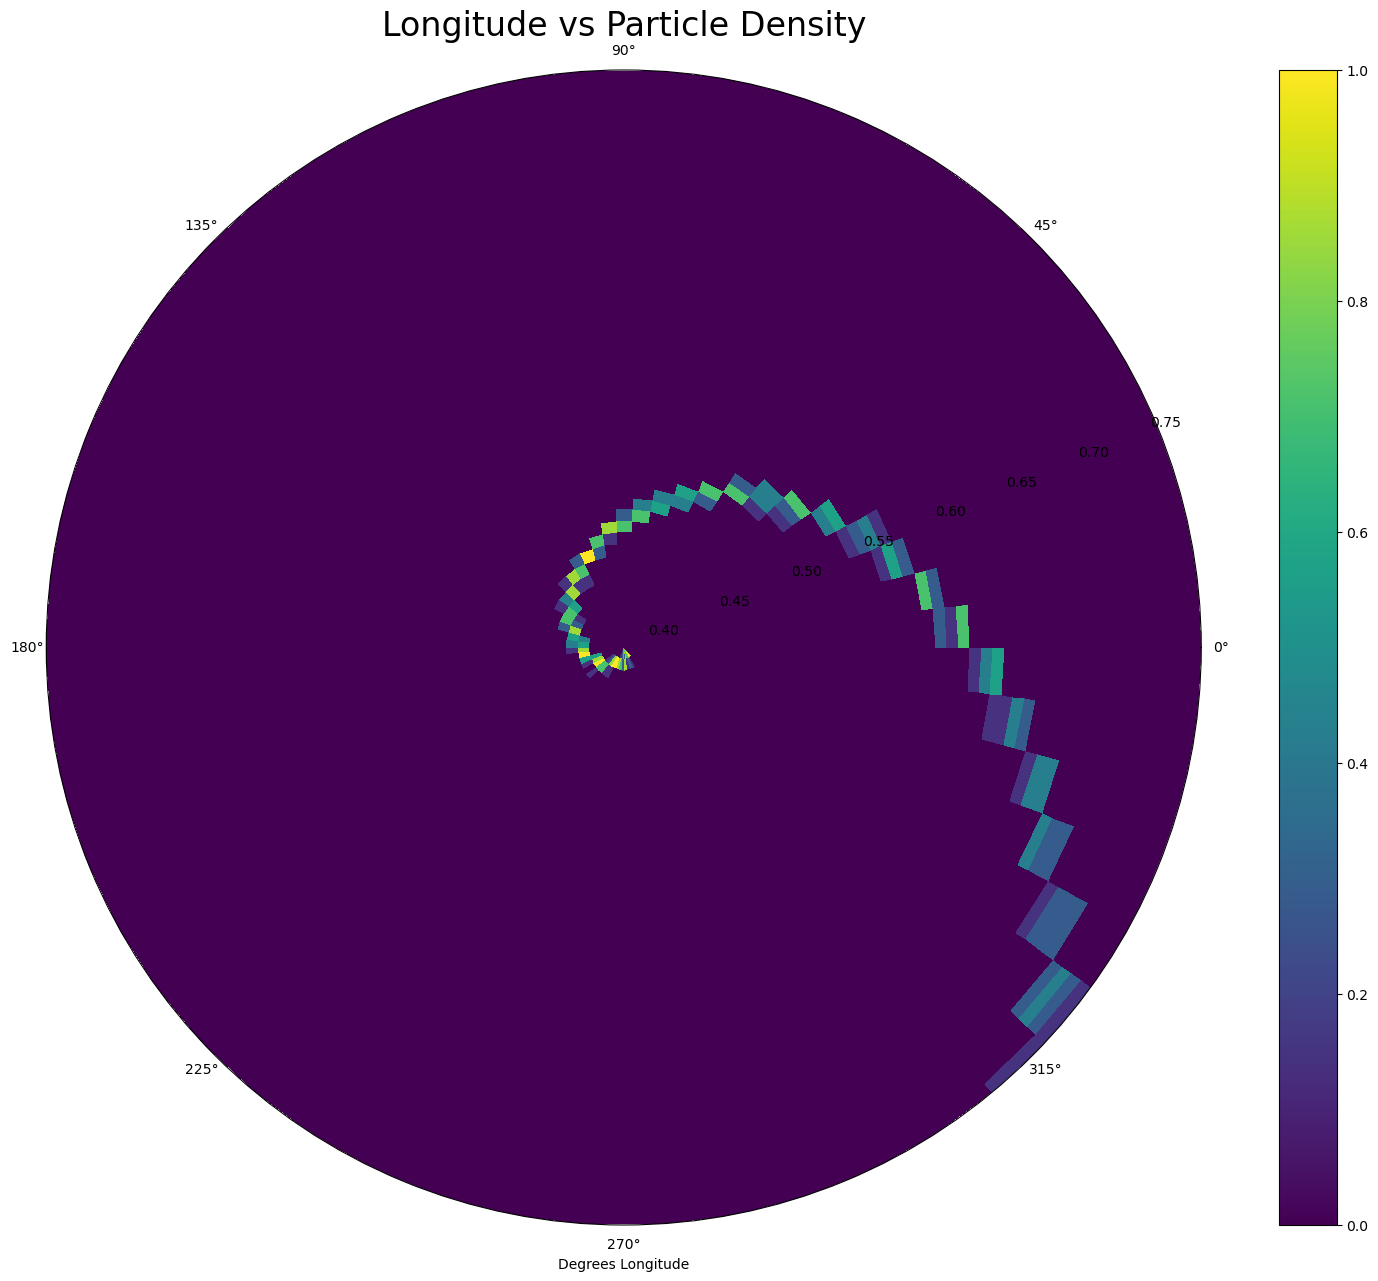

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
fig.colorbar(plt.cm.ScalarMappable(), ax=ax)
plt.title("Longitude vs Particle Density", fontsize = 24)
plt.hist2d(np.linspace(0,2*np.pi,360), counts, bins = 50)
plt.xlabel("Degrees Longitude")
plt.show()

In the above two graphs we can see that the longitude has a significant impact on the distribution of the number of gama rays that we see. In the first graph, we see the mean of the distribution slowly decreases from 0 to 315, then sharply rises at 315, and continue to decrease till 360. The second graph shows the distribution as a polar 2D histogram, where a greater distance from the center is a higher measurement, and degree longitude corosponds directly with the degree around the circle. We begin to see a very interesting pattern appear here. We can actually see the mean grow in a spiral, showing the distribution grow as we go around the circle, then suddenly and sharply snap back to the start at a longitude of 315. From these two graphs, we can see that there is a clear relation between longitude and gamma rays that we count

# 3) Create a model for the background

In [8]:
means = [0]*54000
for i in range(54000):
    means[i] = df["count"][i+40500::54000].mean()


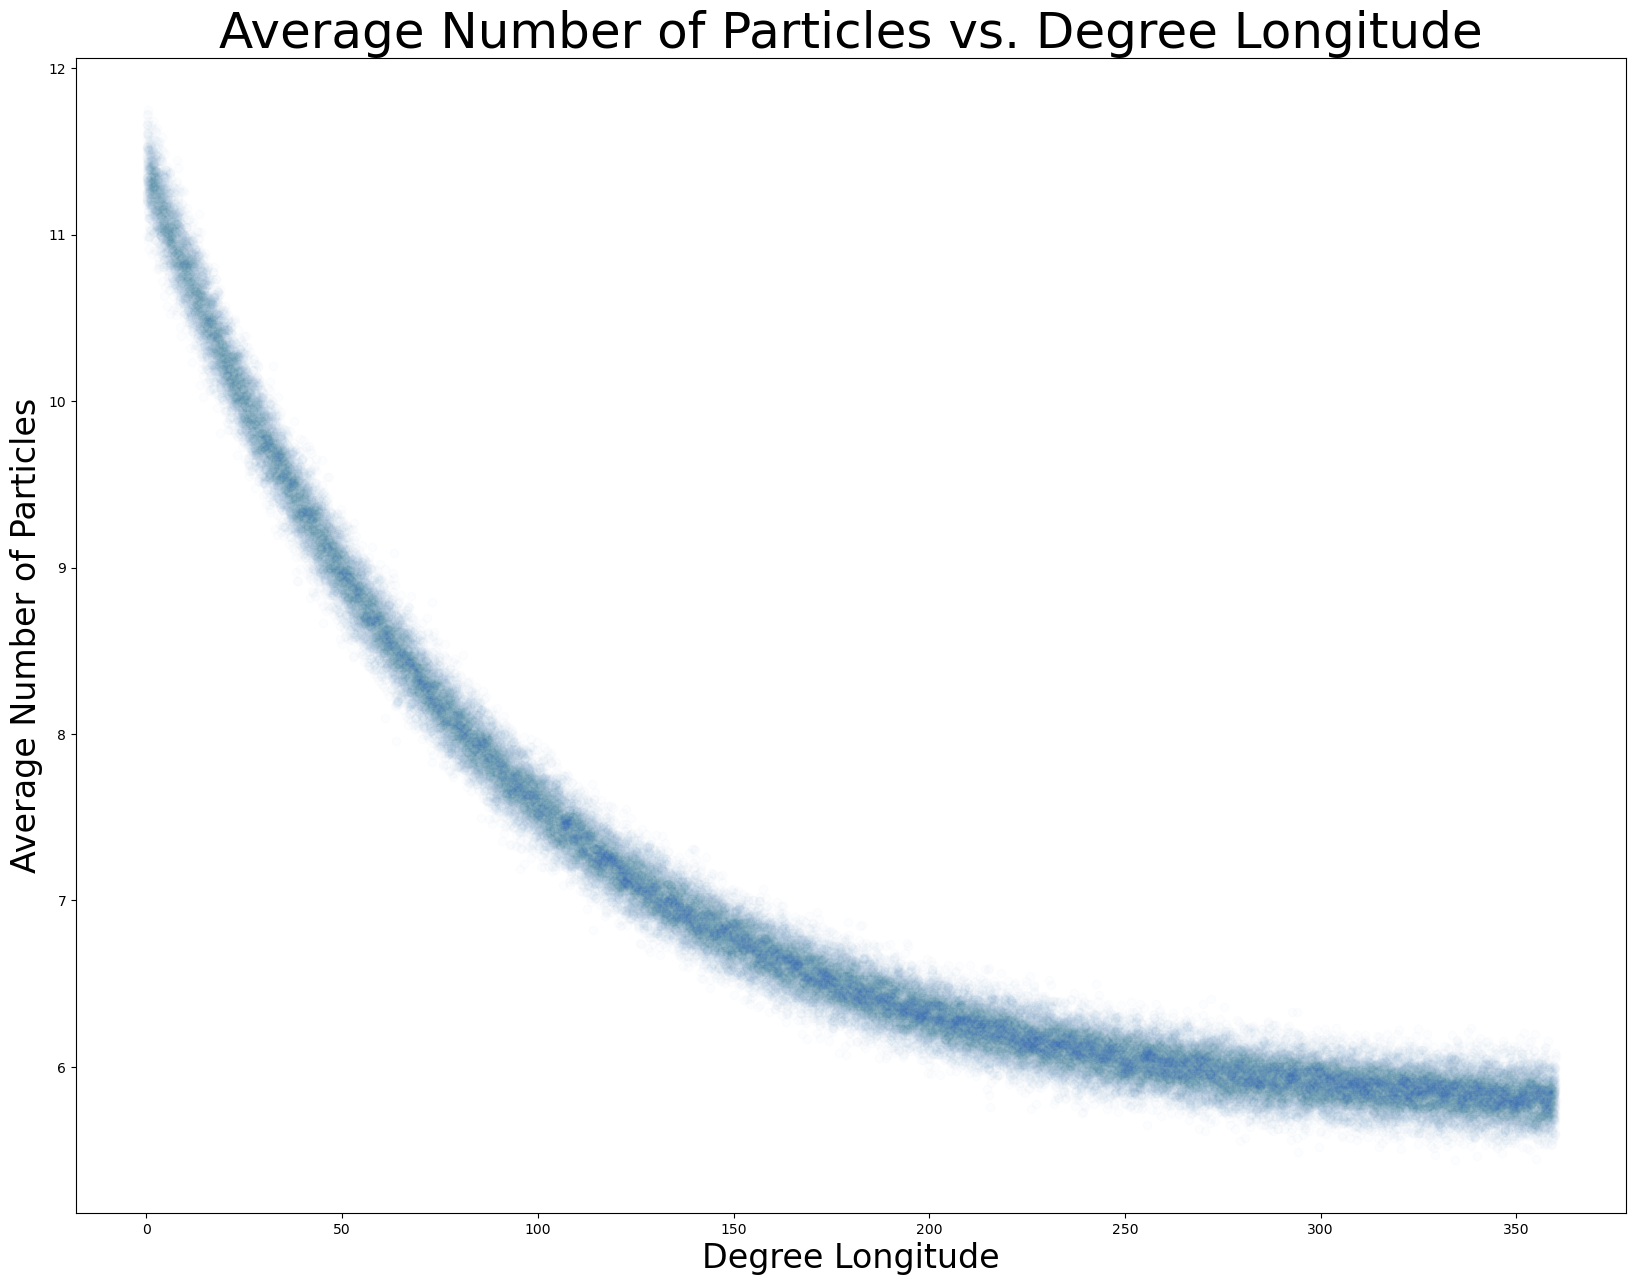

In [9]:
plt.scatter(x = np.linspace(0,360,54000),y = means, alpha = 0.01)
plt.xlabel("Degree Longitude", fontsize = 24)
plt.ylabel("Average Number of Particles", fontsize = 24)
plt.title("Average Number of Particles vs. Degree Longitude", fontsize = 36)
plt.show()

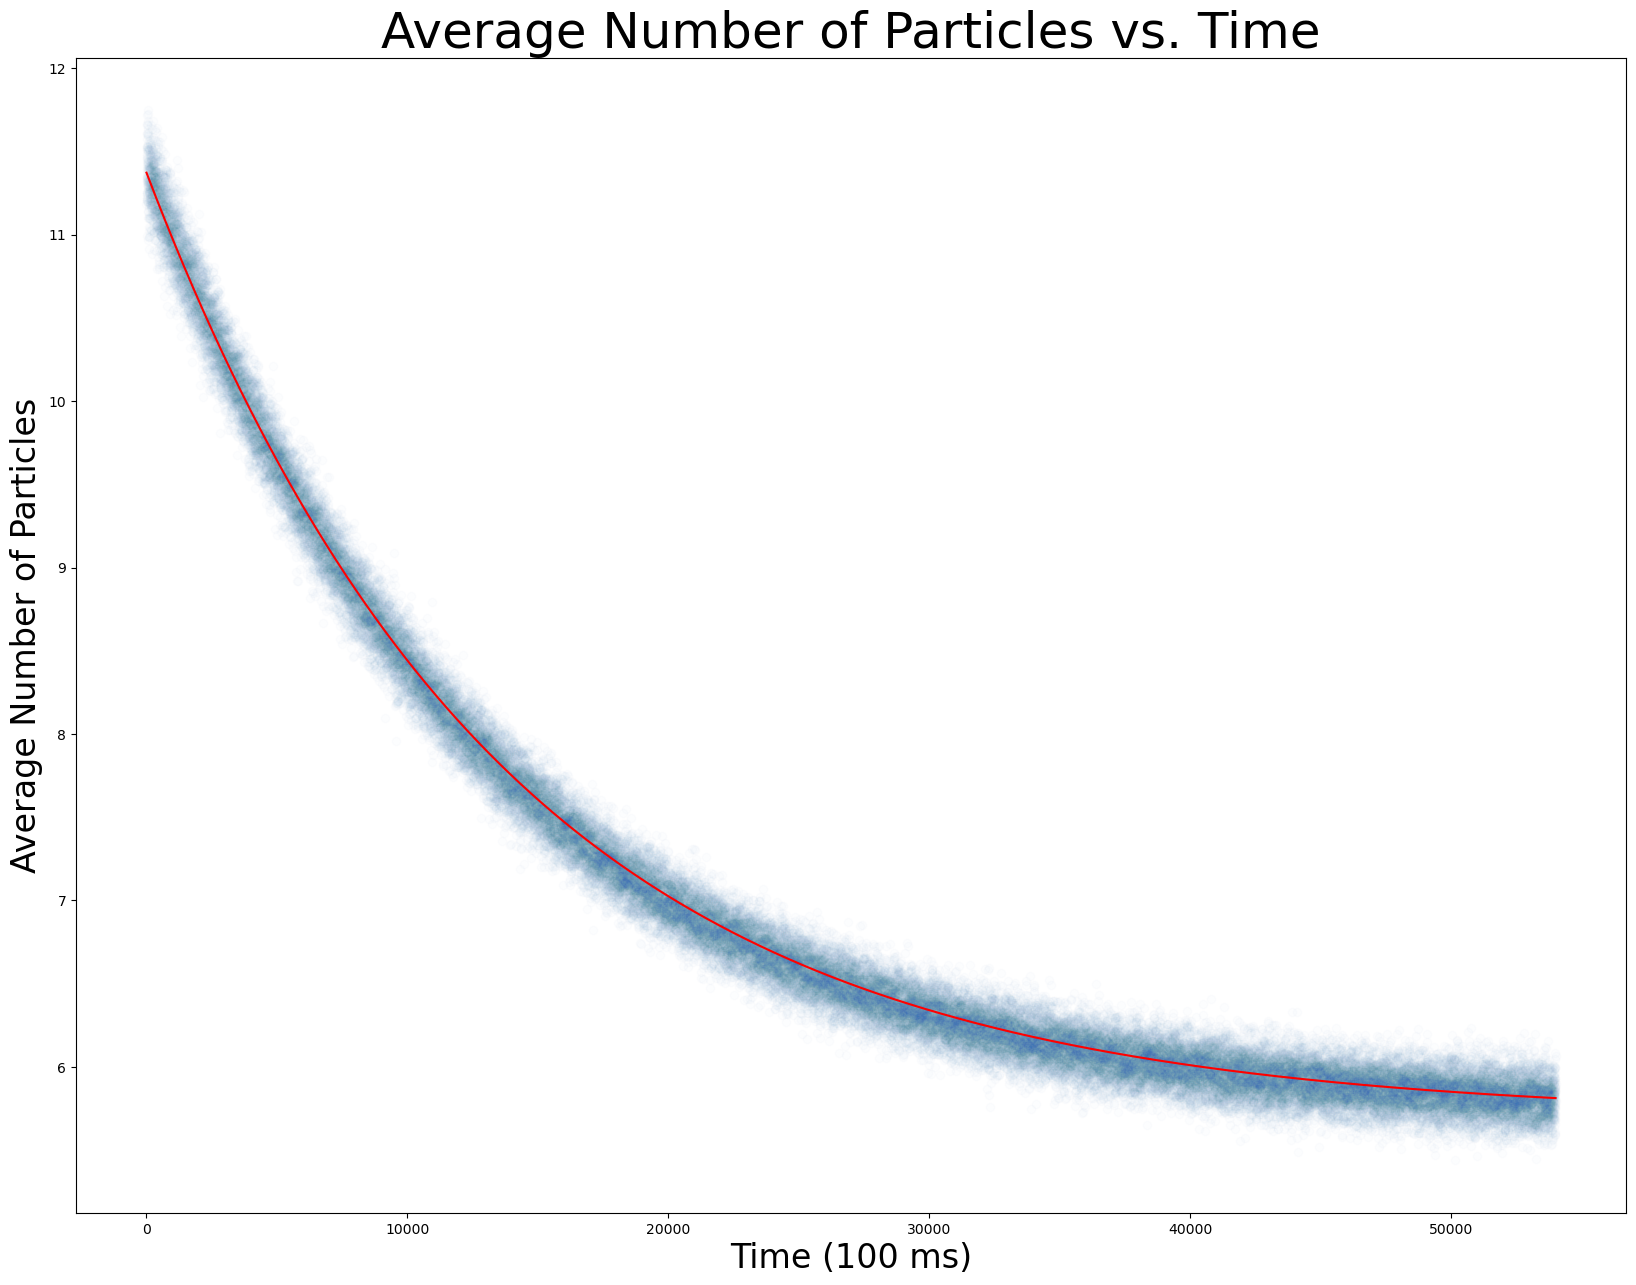

In [10]:
x = np.linspace(0,54000,54000)
y = scipy.stats.expon.pdf(x, scale = 13750)*78000+5.7
plt.scatter(x=x,y = means, alpha = 0.01)
plt.plot(x, y, color = "red")
plt.xlabel("Time (100 ms)", fontsize = 24)
plt.ylabel("Average Number of Particles", fontsize = 24)
plt.title("Average Number of Particles vs. Time", fontsize = 36)
plt.show()

The above two graphs show the mean as a function of time. The first graph is starting at the start of the data set, and plotting the mean of every logitudinal point where data was taken, which are all isochronous. The second shows the same data, except as a function of time, and overlayed with an exponential curve. The plots look the same because longitude is linear with time, which is why we see the x-axis have a different scale. We can see that with some scaling adjustments to the curve, we find a nicely fitting overlay on the data. The equation for such a curve would be $f(t) = \frac{312}{55}e^{\frac{-t}{13750}}+5.57$, where $f(t)$ is number of expected gamma rays, and $t$ is time. This is a fairly accurate model of my data, and contains pretty much all the distribution within about $\pm 0.5$ gamma rays

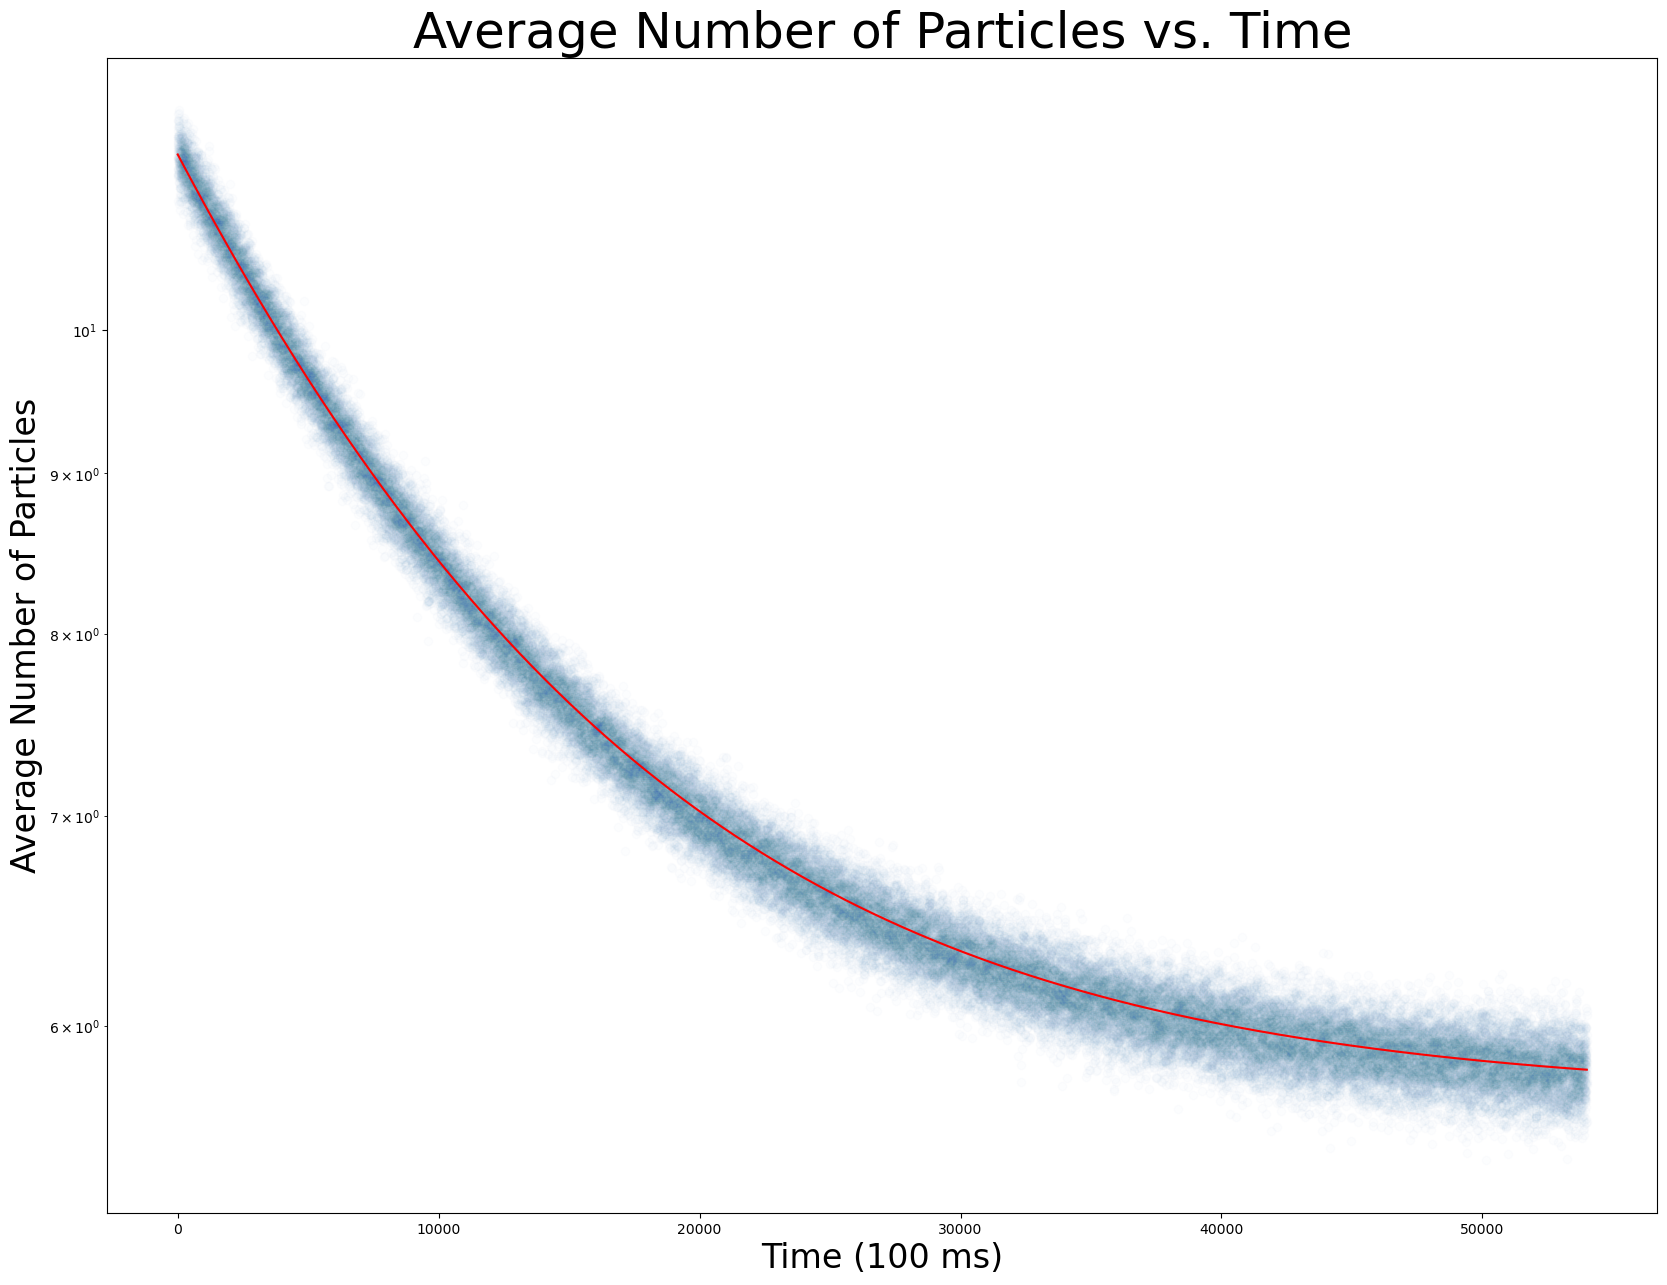

In [11]:
x = np.linspace(0,54000,54000)
y = scipy.stats.expon.pdf(x, scale = 13750)*78000+5.7
plt.scatter(x=x,y = means, alpha = 0.01)
plt.plot(x, y, color = "red")
plt.xlabel("Time (100 ms)", fontsize = 24)
plt.ylabel("Average Number of Particles", fontsize = 24)
plt.title("Average Number of Particles vs. Time", fontsize = 36)
plt.semilogy()
plt.show()

We can see that this hold up even in a semilog representation of the data.

## 4) 5-sigma threshold for a 100 millisecond GRB at different times

In [12]:
dist_per_time = [[-1]]*6
for i in range(6):
    measurements = [-1]*int((len(df["count"])-1)/54000)
    for j in range(math.floor((len(df["count"])-1)/54000)):
        measurements[j] = df["count"][54000*j + i*54000/6]
    dist_per_time[i] = measurements

The above code takes a selection of the data points, and makes a 2D array out of them. The outermost level of the array is the time, and the innermost is the measurement. The times selected were based on the satalites longitude.

In [13]:
means = [-1]*6
std = [-1]*6
for i in range(6):
    print("At a longitude of {} degrees, for a 5 sigma measurement, we need to see at least {} particles come through".format(
        df["longitude"][i*54000/6], (np.mean(dist_per_time[i]) + np.std(dist_per_time[i]) * 5)
    ))

At a longitude of 45.0 degrees, for a 5 sigma measurement, we need to see at least 21.000329562764158 particles come through
At a longitude of 105.0 degrees, for a 5 sigma measurement, we need to see at least 19.191318278294894 particles come through
At a longitude of 165.0 degrees, for a 5 sigma measurement, we need to see at least 18.106998931249105 particles come through
At a longitude of 225.0 degrees, for a 5 sigma measurement, we need to see at least 18.44609423006864 particles come through
At a longitude of 285.0 degrees, for a 5 sigma measurement, we need to see at least 17.18024874477308 particles come through
At a longitude of 345.0 degrees, for a 5 sigma measurement, we need to see at least 25.54554749152929 particles come through


In order to find a 5 sigma measurement, I calculated the mean of the data points for the distinct logitudes. Then I found the standard deviation of the data set. I multiplied the standard deviation by 5 and added the mean in order to find the minimum required value for a measurement of 5 sigma.

# Problem 2

## 1) Download the data

In [14]:
hf = h5py.File('images.h5', 'r')
data = np.array(hf.get('imagestack'))

## 2) Explore the data

We are looking for transient events, which are very time depenent, and very localized. Given that we only have 10 temporal data points for each pixel, it would be very difficult to find a 5 sigma event if we were to include it in our data set, since it would skew not only the mean, but the standard deviation by a lot. This shows that any potential signal that we have would contaminate the data.

Below, we are testing for the time dependence of the background by finding the average brightness of each image

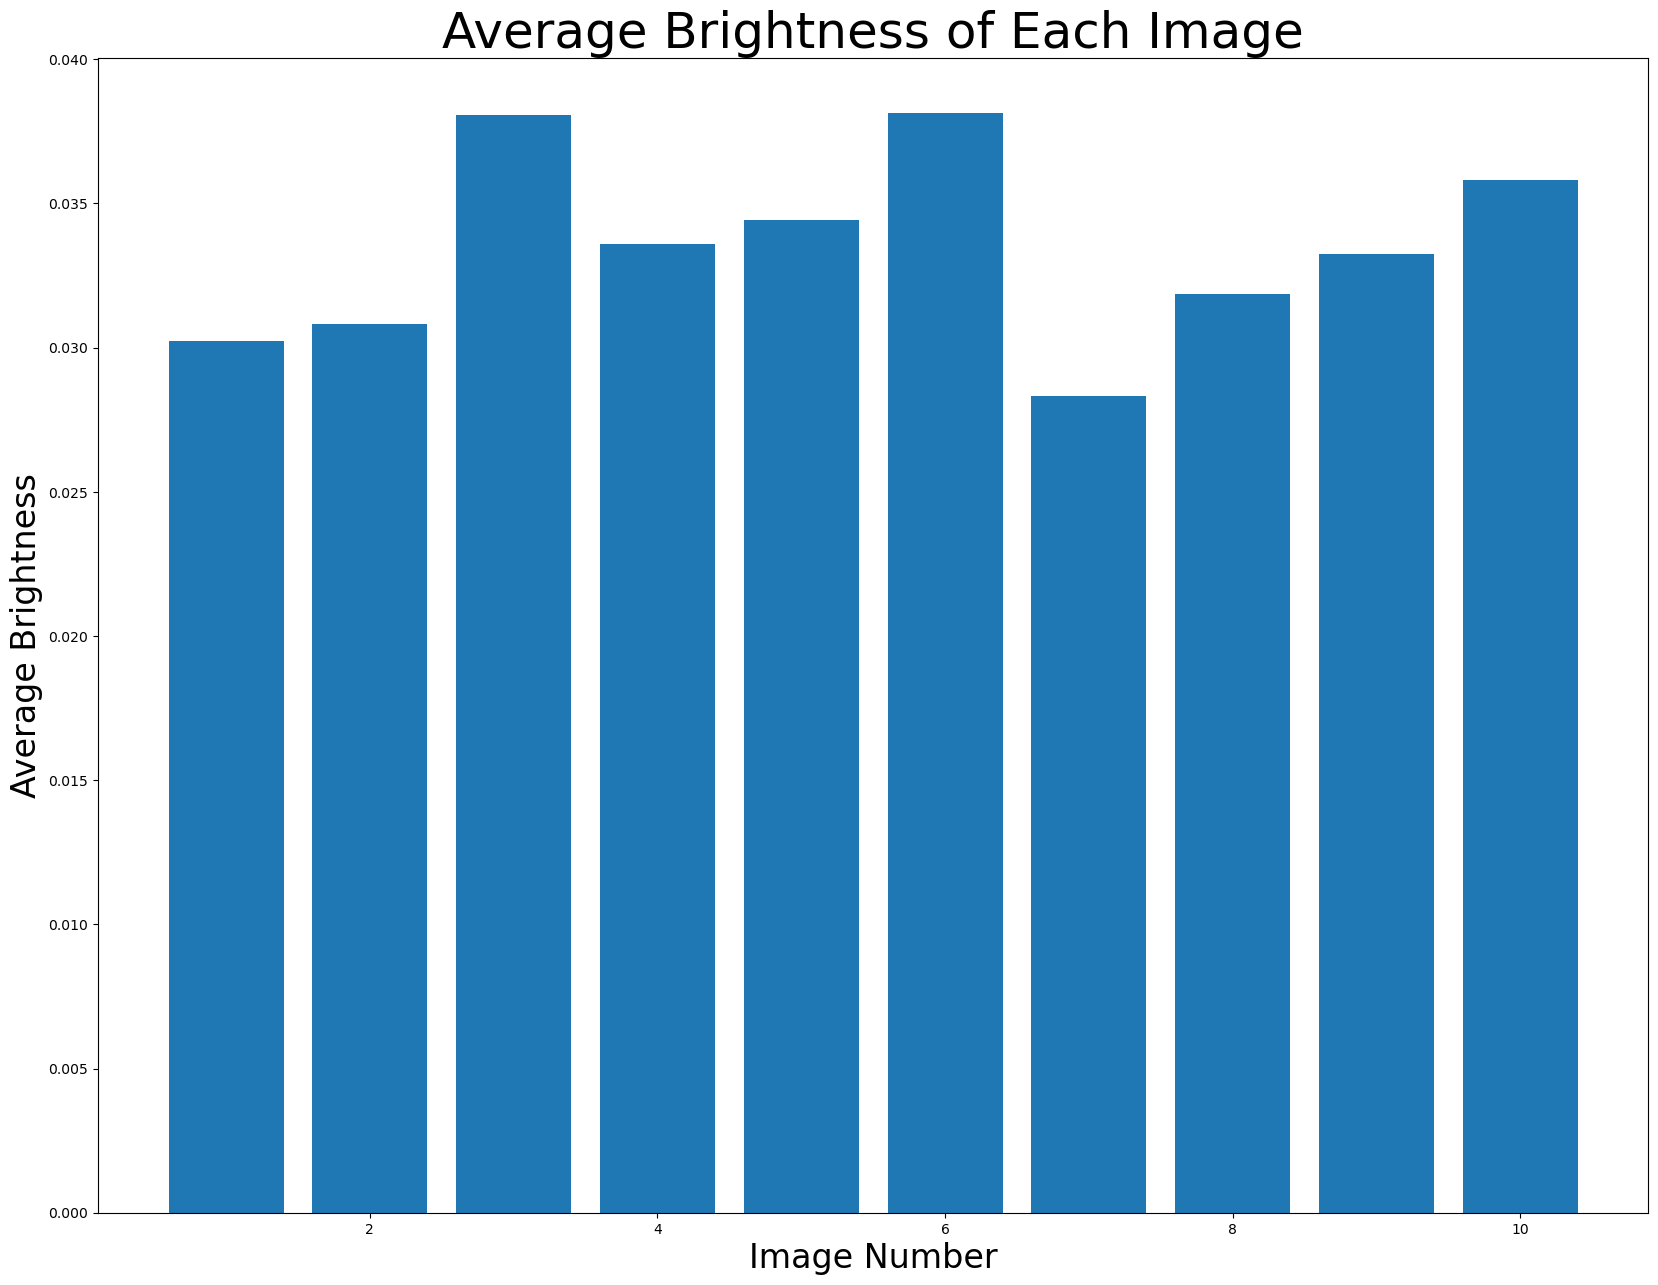

In [15]:
avgBrightness = [0]*10
for image in range(10):
    for row in range(200):
        for column in range(200):
            avgBrightness[image] += data[row][column][image]/(200*200)
plt.bar(x = np.linspace(1,10,10), height = avgBrightness)
plt.ylabel("Average Brightness", fontsize = 24)
plt.xlabel("Image Number", fontsize = 24)
plt.title("Average Brightness of Each Image", fontsize = 36)
plt.show()


Although the brightness varies over time, we cannot say that it is anything more than backgroun noise in the variation. We see that the brightness is around 0.032 on average, but can be as high as 0.038 or as low as 0.030. However, we cannot say that there is an implicit time dependence here.

Given the above two important facts discusse above, we can use the lack of time dependence to help resolve our signal contamination. To combat it, I'm going to only find the pixels that at any given time are 5 sigma brighter than the entire background mean. Once I have my list of pixels, I'm going to take the brightest time of that pixel out of the data, in order to remove this potential signal. This will remove any contamination of the signal from the data set. From there, I will find the mean and standard deviation of the 9 data points for that pixel, and use this to compare my candidate. If there is a time based spacial variance, we will be able to see this, as our bright points will begin to move around in the image. 

## 3) Hunt for your signal

In [16]:
# Step 1, find any time any pixel is 5 sigma brighter than the
brightSpots = []
flat_data = np.reshape(data, (200*200*10))
std = np.std(flat_data)
mean = np.mean(flat_data)
for row in range(200):
    for column in range(200):
        for i in range(10):
            if data[row][column][i] > mean + 5 * abs(std):
                brightSpots.append([row,column])

# Step 2, find the brightest time for each pixel, and remove it from the data
for spot in brightSpots:
    maxBright = -1
    for pixel in data[spot[0]][spot[1]]:
        if pixel > maxBright:
            maxBright = pixel
    testData = []
    for pixel in data[spot[0]][spot[1]]:
        if pixel != maxBright:
            testData.append(pixel)
    
    # Step 3, find the mean and sd of the signalless data
    px_std = np.std(testData)
    px_mean = np.mean(testData)
    
    # Step 4, find the significance of the brightest point
    sigma = (maxBright-px_mean)/px_std
    if sigma > 5:
        print("5 Sigma event at ({},{})\n\tMean:\t{}\n\tSD\t{}\n\tMax:\t{}".format(spot[0], spot[1],px_mean, px_std, maxBright))

5 Sigma event at (55,175)
	Mean:	4.848248577699359
	SD	0.2541911482256557
	Max:	6.256748978363732
5 Sigma event at (55,175)
	Mean:	4.848248577699359
	SD	0.2541911482256557
	Max:	6.256748978363732
5 Sigma event at (55,175)
	Mean:	4.848248577699359
	SD	0.2541911482256557
	Max:	6.256748978363732
5 Sigma event at (171,197)
	Mean:	14.524284878815791
	SD	0.17286980377070696
	Max:	15.487032081621573
5 Sigma event at (171,197)
	Mean:	14.524284878815791
	SD	0.17286980377070696
	Max:	15.487032081621573
5 Sigma event at (171,197)
	Mean:	14.524284878815791
	SD	0.17286980377070696
	Max:	15.487032081621573
5 Sigma event at (171,197)
	Mean:	14.524284878815791
	SD	0.17286980377070696
	Max:	15.487032081621573
5 Sigma event at (171,197)
	Mean:	14.524284878815791
	SD	0.17286980377070696
	Max:	15.487032081621573
5 Sigma event at (171,197)
	Mean:	14.524284878815791
	SD	0.17286980377070696
	Max:	15.487032081621573
5 Sigma event at (171,197)
	Mean:	14.524284878815791
	SD	0.17286980377070696
	Max:	15.48703208

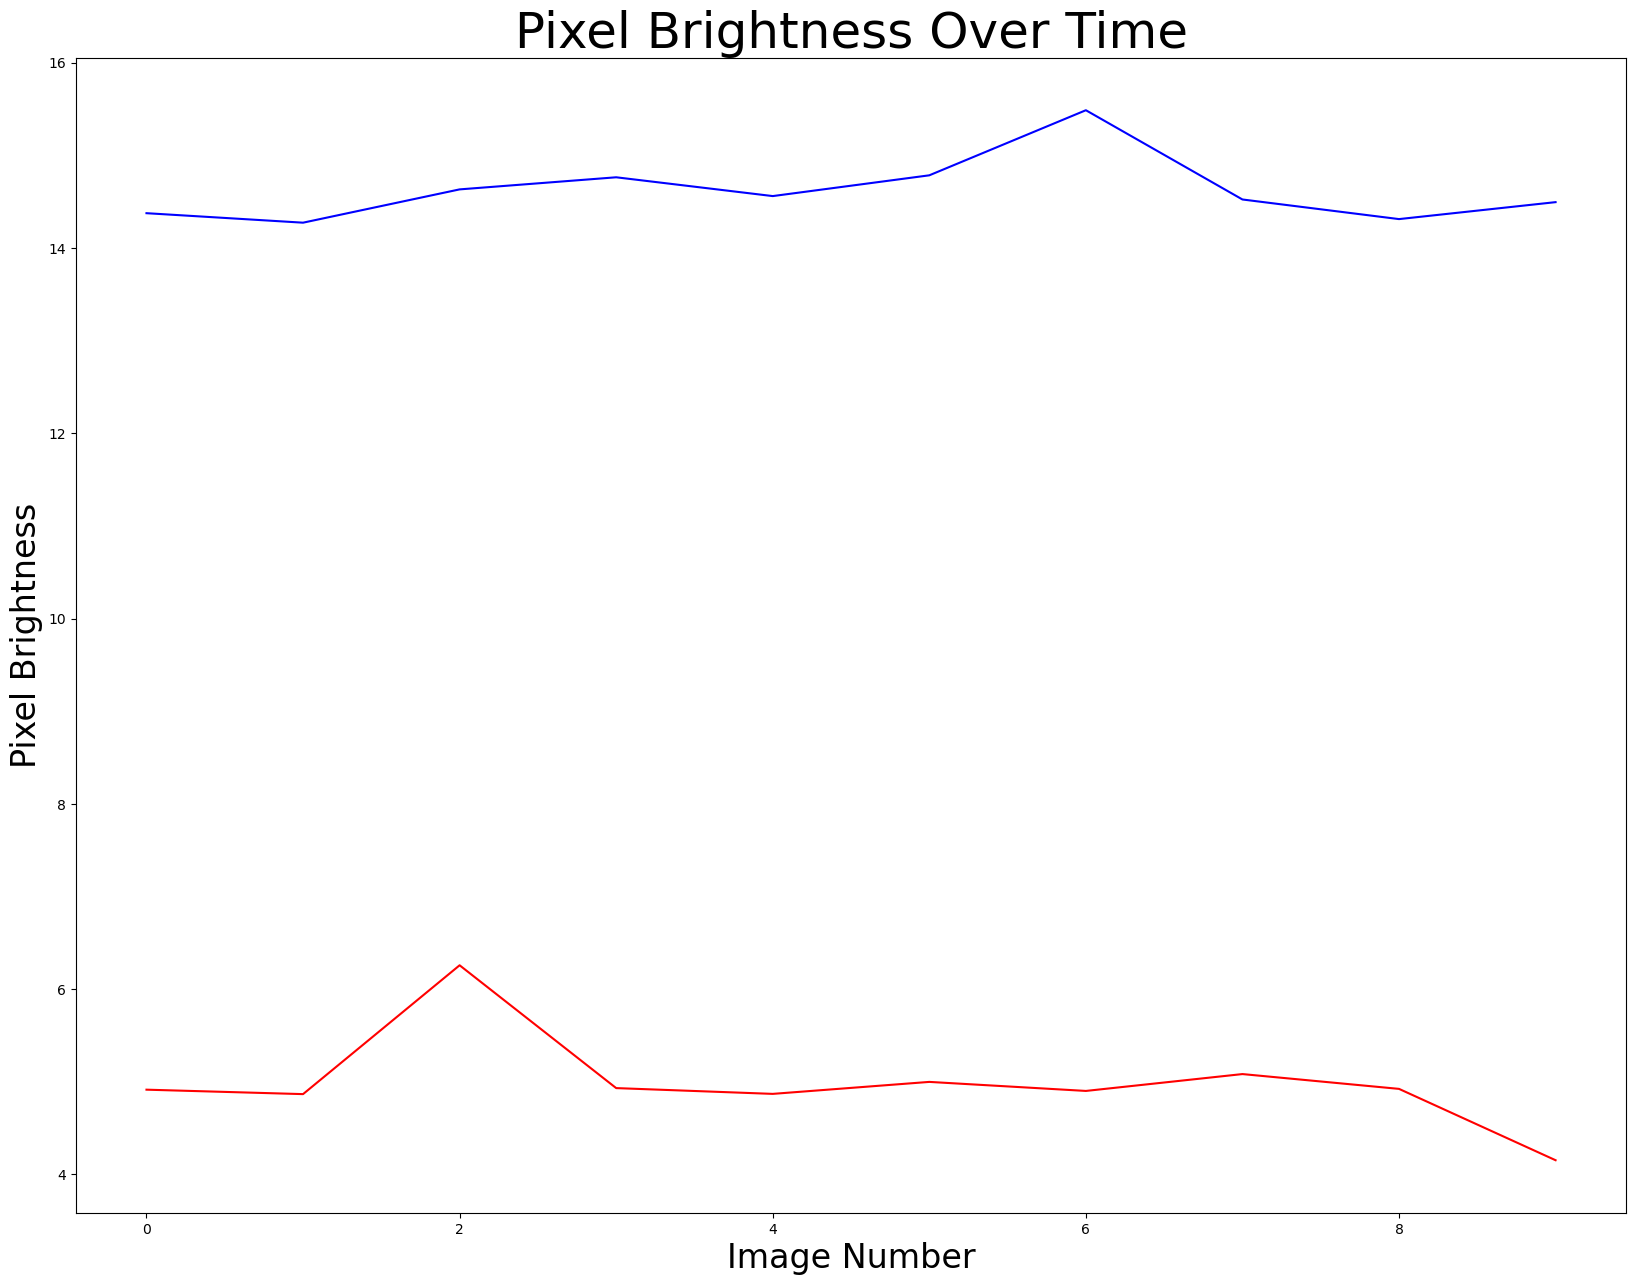

In [17]:
fix, ax = plt.subplots()
ax.plot(data[55][175], color = 'red')
ax.plot(data[171][197], color = 'blue')
plt.ylabel("Pixel Brightness", fontsize = 24)
plt.xlabel("Image Number", fontsize = 24)
plt.title("Pixel Brightness Over Time", fontsize = 36)
plt.show()

In the above graph, we see the pixel at (171, 197) have a very high, yet very consistent brightness. We see that the pixel has a semi-sharp spike in brightness in image 7, with a noticeable downtick in the next two frames. We see a much more significant event in image 3 of the pixel at (55,175). This pixel has a low steay brightness, with a large sharp spike in image 3. This is followed by a return to the normal level, followed by a slight decrease in the last two images. 

## 4) Why is the PDF different? 

In my lab, my pdf is designed to look for an occurence in time, while my partners is designed to look at an occurence in space. Because of this, we need to leverage opposite axes to for the distribution. I'm looking at distributions over time, while they are looking at distributions over space. I can use space to get an average for all each time, while they can use time to get an average over all space.